In [1]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
from IPython.display import display # データフレーム表示用関数
import seaborn as sns
import pymc as pm
import arviz as az
# 表示オプション調整
# NumPy表示形式の設定
np.set_printoptions(precision=3, floatmode="fixed")
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# サイズ設定
plt.rcParams["figure.figsize"] = (6, 6)
# 方眼表示ON
plt.rcParams["axes.grid"] = True
# データフレームでの表示精度
pd.options.display.float_format = "{:.3f}".format
# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Code 5.1.1 データの読み込みと確認

df = sns.load_dataset("iris")
display(df.head())
df["species"].value_counts()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.100,3.500,1.400,0.200,setosa
1,4.900,3.000,1.400,0.200,setosa
2,4.700,3.200,1.300,0.200,setosa
3,4.600,3.100,1.500,0.200,setosa
4,5.000,3.600,1.400,0.200,setosa


species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

花 (versicolor) のがく片の長さ (sepal_length) と幅 (sepal_width) の間に線形の関係があると仮定して分析する．<br>
１次関数の傾きと切片の取り得る値をベイズ推定する．

In [3]:
# Code 5.2.1 分析対象データ抽出

# versicolorの行のみ抽出
df1 = df.query('species == "versicolor"')

# sepal_lengthとsepal_width列を抽出
X = df1["sepal_length"]
Y = df1["sepal_width"]

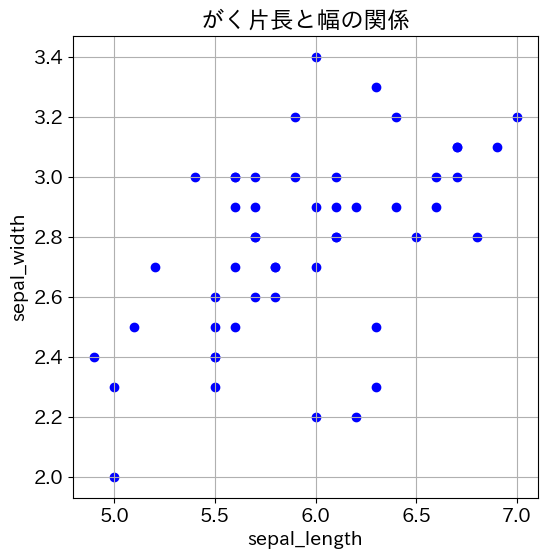

In [4]:
# Code 5.2.2 散布図の描画

plt.title("がく片長と幅の関係")
plt.scatter(X, Y, c="b", marker="o")
plt.xlabel("sepal_length")
plt.ylabel("sepal_width");

次の単純回帰モデルを考える．
$$
Y_i = \alpha X_i + \beta + \epsilon_i
$$
誤差項 $\epsilon_i$ は標準偏差`epsilon`の正規分布に従うと仮定する．<br>
各パラメータの事前分布は次の通りである．
$$
\alpha \sim N(0.0,10^2),~~~~ \beta \sim N(0.0,10^2),~~~~ \epsilon_i \sim \text{HalfNormal}(1^2)
$$

In [5]:
# Code 5.2.3 線形回帰の確率モデル定義その１

model1 = pm.Model()
with model1:
    # 確率変数 alpha, beta の定義(一次関数の傾きと切片)
    alpha = pm.Normal("alpha", mu=0.0, sigma=10.0)
    beta = pm.Normal("beta", mu=0.0, sigma=10.0)

    #　誤差を示す確率変数epsilonの定義
    epsilon = pm.HalfNormal("epsilon", sigma=1.0)

    # 平均値 mu の計算
    mu = alpha * X + beta

    # データ生成過程
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=epsilon, observed=Y)


In [ ]:
# Code 5.2.4 確率モデル構造の可視化その１

g = pm.model_to_graphviz(model1)
display(g)

In [6]:
# Code 5.2.5 線形回帰の確率モデル定義その２

model2 = pm.Model()
with model2:
    # X, Yの観測値を ConstantData として定義
    X_data = pm.ConstantData("X_data", X)
    Y_data = pm.ConstantData("Y_data", Y)

    # 確率変数 alpha, beta の定義(一次関数の傾きと切片)
    alpha = pm.Normal("alpha", mu=0.0, sigma=10.0)
    beta = pm.Normal("beta", mu=0.0, sigma=10.0)

    #　誤差を示す確率変数epsilonの定義
    epsilon = pm.HalfNormal("epsilon", sigma=1.0)

    # 平均値 mu の計算
    mu = pm.Deterministic("mu", alpha * X_data + beta)

    # データ生成過程
    obs = pm.Normal("obs", mu=mu, sigma=epsilon, observed=Y_data)

In [ ]:
# Code 5.2.6 確率モデル構造の可視化その２

g = pm.model_to_graphviz(model2)
display(g)

In [7]:
# Code 5.2.7 MCMCサンプリング

with model2:
    idata2 = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, epsilon]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


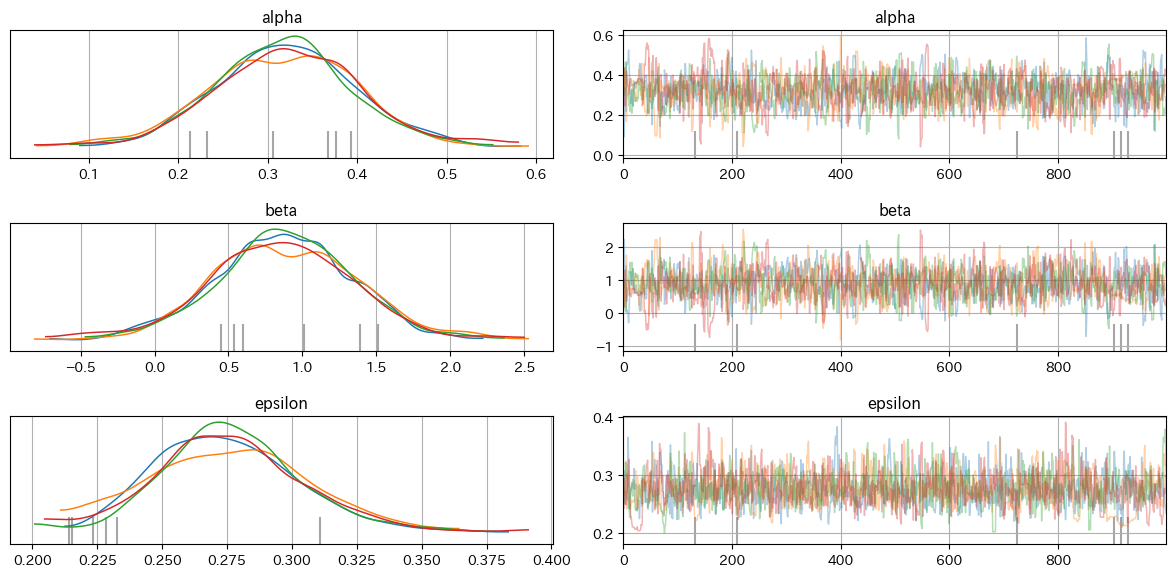

In [8]:
# Code 5.2.8 サンプリングの正常性を確認

ax = az.plot_trace(idata2, compact=False, var_names=["alpha", "beta", "epsilon"])
plt.tight_layout();

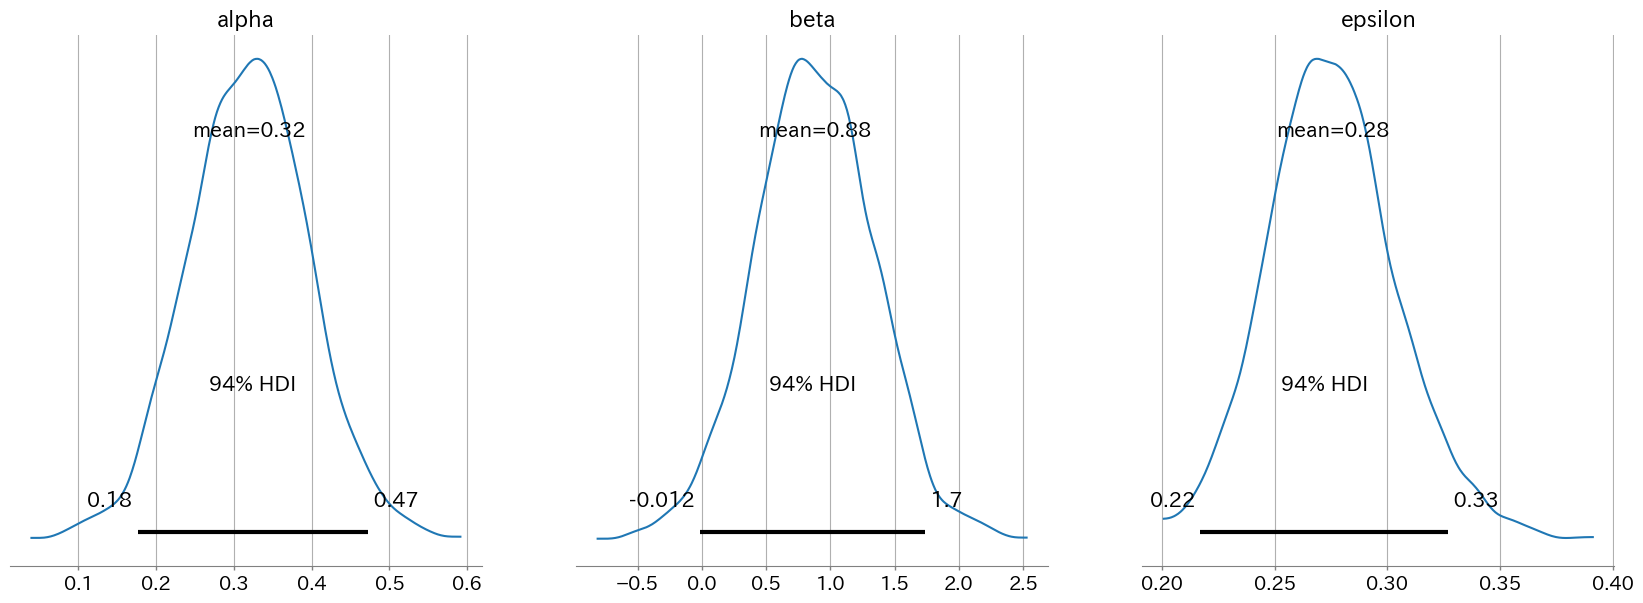

In [9]:
# Code 5.2.9 事後分布の可視化

az.plot_posterior(idata2, var_names=["alpha", "beta", "epsilon"]);

In [10]:
# Code 5.2.10 サンプルサイズ1000*chain数の個々のサンプルに対応する回帰直線を求める準備

# 直線を描くための X の下限と上限（2点）を取り出す
X_values = np.array([X.min()-0.1, X.max()+0.1])
print(X_values, X_values.shape)

# サンプリング結果から alpha と beta を取り出し，shape が (4000, 1) の２次元配列に加工する
alphas2 = idata2["posterior"]["alpha"].values.reshape(-1, 1)
betas2 = idata2["posterior"]["beta"].values.reshape(-1, 1)
print(alphas2.shape, betas2.shape)

# 4000パターンの予測値のペアを求める
y_preds = alphas2 * X_values + betas2
print(y_preds.shape)

[4.800 7.100] (2,)
(4000, 1) (4000, 1)
(4000, 2)


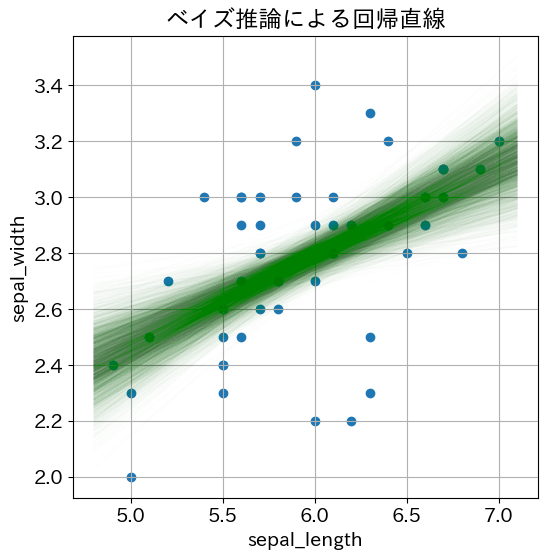

In [11]:
# Code 5.2.11 散布図と回帰直線

for y_pred in y_preds:
    plt.plot(X_values, y_pred, lw=1, alpha=0.009, c="g")
plt.scatter(X, Y)
plt.title("ベイズ推論による回帰直線")
plt.xlabel("sepal_length")
plt.ylabel("sepal_width");

通常，ベイズ推論はサンプルサイズが小さく，予測にとって難しい条件で行われる．<br>
ここでは，サンプルサイズを3にしてベイス推論を実行する．

In [12]:
# Code 5.2.12 サンプルの無作為抽出

import random
random.seed(42)
indexes =range(len(X))
sample_indexes=random.sample(indexes, 3)
print("インデックス値", sample_indexes)

# データ数を3個にする
X_less = X.iloc[sample_indexes]
Y_less = Y.iloc[sample_indexes]
print("xの値", X_less.values)
print("yの値", Y_less.values)

インデックス値 [40, 7, 1]
xの値 [5.500 4.900 6.400]
yの値 [2.600 2.400 3.200]


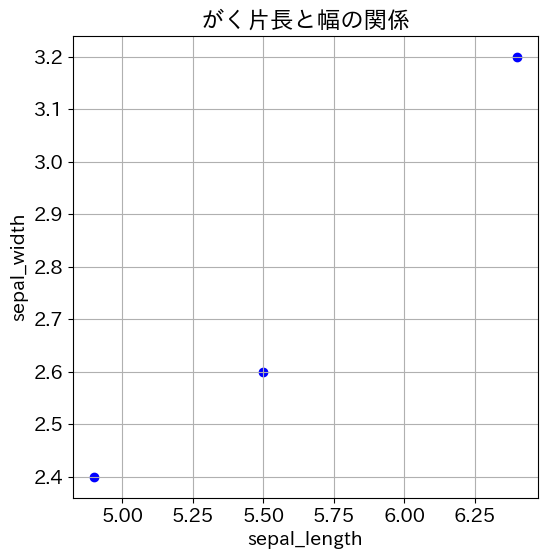

In [13]:
# Code 5.2.13 散布図描画

plt.title("がく片長と幅の関係")
plt.scatter(X_less, Y_less, c="b", marker="o")
plt.xlabel("sepal_length")
plt.ylabel("sepal_width");

In [14]:
# Code 5.2.14 確率モデル定義とMCMCサンプリング

model3 = pm.Model()
with model3:
    # X, Yの観測値を ConstantData として定義
    X_data = pm.ConstantData("X_data", X_less)
    Y_data = pm.ConstantData("Y_data", Y_less)

    # 確率変数 alpha, beta の定義(一次関数の傾きと切片)
    alpha = pm.Normal("alpha", mu=0.0, sigma=10.0)
    beta = pm.Normal("beta", mu=0.0, sigma=10.0)

    #　誤差を示す確率変数epsilonの定義
    epsilon = pm.HalfNormal("epsilon", sigma=1.0)

    # 平均値 mu の計算
    mu = pm.Deterministic("mu", alpha * X_data + beta)

    # データ生成過程
    obs = pm.Normal("obs", mu=mu, sigma=epsilon, observed=Y_data)

    # MCMCサンプリング
    idata3 = pm.sample(random_seed=42, target_accept=0.995)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, epsilon]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


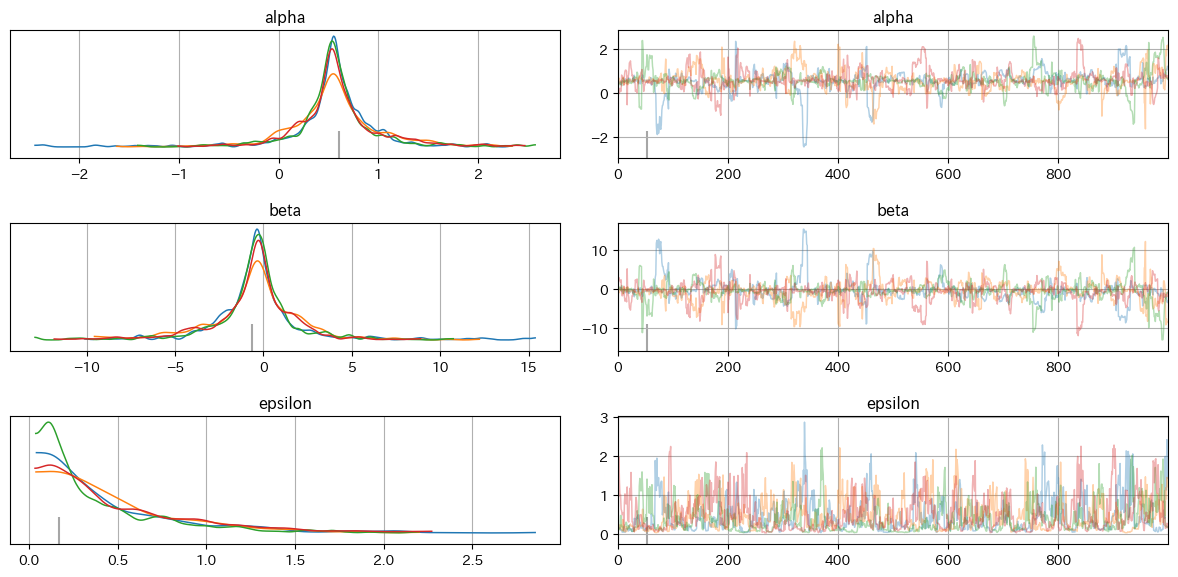

In [15]:
# Code 5.2.15 サンプリングの正常性確認

az.plot_trace(idata3, compact=False, var_names=["alpha", "beta", "epsilon"])
plt.tight_layout();

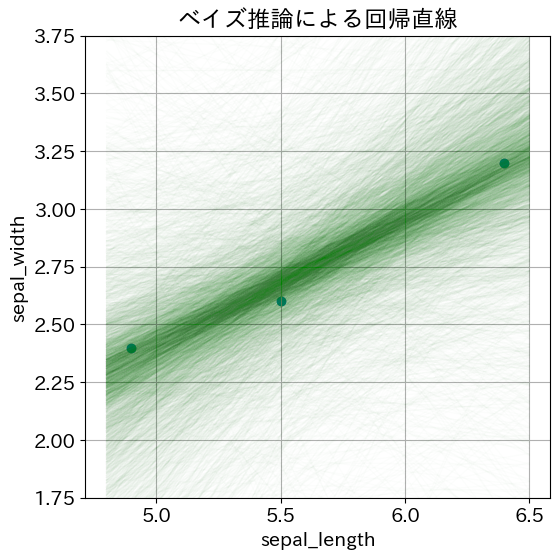

In [16]:
# Code 5.2.16 散布図と回帰直線

# 直線を描くための X の下限と上限（2点）を取り出す
x_values = np.array([X_less.min()-0.1, X_less.max()+0.1])

# サンプル値からalphaとbetaを取り出しshapeを加工する
alphas3 = idata3["posterior"]["alpha"].values.reshape(-1, 1)
betas3 = idata3["posterior"]["beta"].values.reshape(-1, 1)

# 4000パターンそれぞれで、２点の１次関数値の計算
y_preds = x_values * alphas3 + betas3

# 4000組の直線を散布図と同時表示
for y_pred in y_preds:
    plt.plot(x_values, y_pred, lw=1, alpha=0.01, c="g")
plt.scatter(X_less, Y_less)
plt.ylim(1.75, 3.75)
plt.title("ベイズ推論による回帰直線")
plt.xlabel("sepal_length")
plt.ylabel("sepal_width");

Column: `target_accept`によるチューニング

In [17]:
# Code 5.2.17 target_acceptパラメータなしの場合の確率モデル定義とサンプリング

model4 = pm.Model()
with model4:
    # X, Yの観測値を ConstantData として定義
    X_data = pm.ConstantData("X_data", X_less)
    Y_data = pm.ConstantData("Y_data", Y_less)

    # 確率変数 alpha, beta の定義(一次関数の傾きと切片)
    alpha = pm.Normal("alpha", mu=0.0, sigma=10.0)
    beta = pm.Normal("beta", mu=0.0, sigma=10.0)

    #　誤差を示す確率変数epsilonの定義
    epsilon = pm.HalfNormal("epsilon", sigma=1.0)

    # 平均値 mu の計算
    mu = pm.Deterministic("mu", alpha * X_data + beta)

    # データ生成過程
    obs = pm.Normal("obs", mu=mu, sigma=epsilon, observed=Y_data)

    # MCMCサンプリング
    idata4 = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, epsilon]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 354 divergences after tuning. Increase `target_accept` or reparameterize.


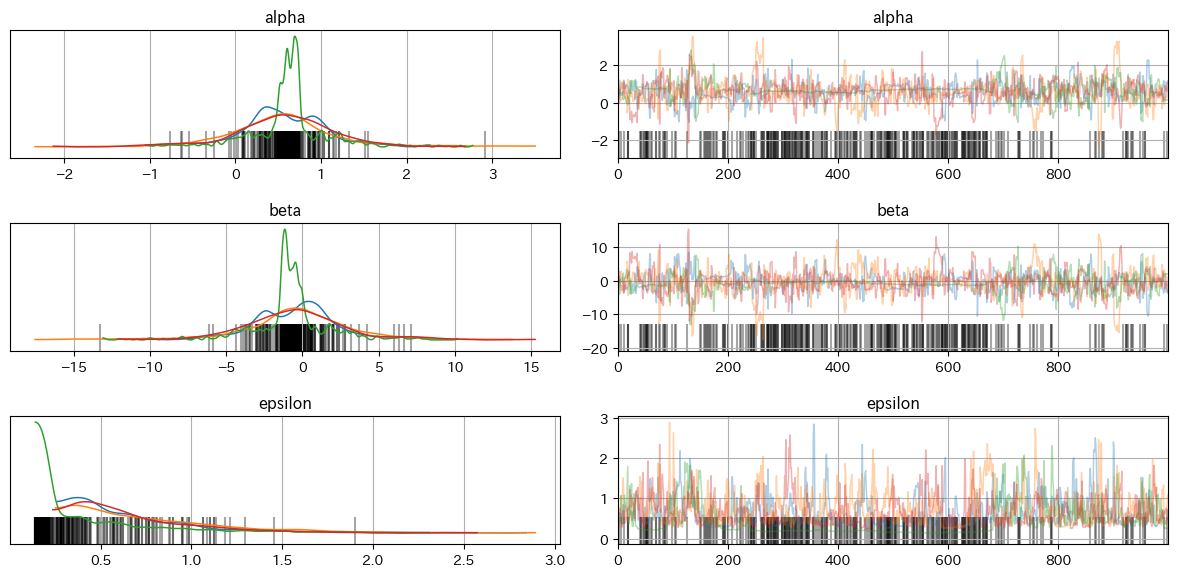

In [18]:
# Code 5.2.18 サンプリングの正常性確認

az.plot_trace(idata4, compact=False, var_names=["alpha", "beta", "epsilon"])
plt.tight_layout();

サンプリングの過程で発散が生じてしまっている．収束が不十分でベイズ推論が上手くいっていないことは，次のコードでも確認できる．<br>
ベイズ推論が上手くいっている指標として `r_hat` $\leq$ 1.01 があるが，すべてのパラメータで上回っている．

In [19]:
# Code5.2.19 事後分布の統計分析

summary4 = az.summary(idata4, var_names=["alpha", "beta", "epsilon"])
display(summary4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.579,0.582,-0.583,1.771,0.024,0.019,589.000,564.000,1.050
beta,-0.507,3.288,-6.054,7.291,0.137,0.111,577.000,560.000,1.050
epsilon,0.625,0.407,0.139,1.387,0.052,0.037,22.000,17.000,1.120


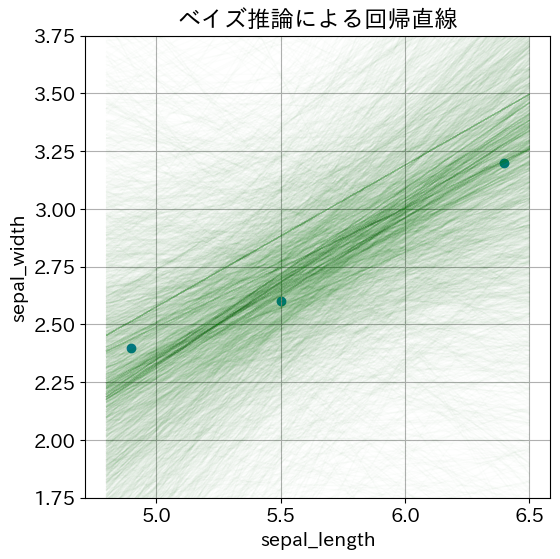

In [20]:
# Code 5.2.20 散布図と回帰直線

# 直線を描くための X の下限と上限（2点）を取り出す
x_values = np.array([X_less.min()-0.1, X_less.max()+0.1])

# サンプル値からalphaとbetaを取り出しshapeを加工する
alphas4 = idata4["posterior"]["alpha"].values.reshape(-1, 1)
betas4 = idata4["posterior"]["beta"].values.reshape(-1, 1)

# 4000パターンそれぞれで、２点の１次関数値の計算
y_preds = x_values * alphas4 + betas4

# 4000組の直線を散布図と同時表示
for y_pred in y_preds:
    plt.plot(x_values, y_pred, lw=1, alpha=0.01, c="g")
plt.scatter(X_less, Y_less)
plt.ylim(1.75, 3.75)
plt.title("ベイズ推論による回帰直線")
plt.xlabel("sepal_length")
plt.ylabel("sepal_width");